In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import timeit
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve
from scipy import interp
# from imblearn.under_sampling import RandomUnderSampler

In [2]:
#set random seed
rs=3

In [3]:
data=pd.read_csv('part2_data.csv')

In [4]:
data.head()

,drv_age1,vh_age,vh_cyl,vh_din,pol_bonus,vh_sale_begin,vh_sale_end,vh_value,vh_speed,claim_amount,made_claim
0,54,11,1461,101,0.5,12,10,18950,179,0.00,0
1,69,7,1461,86,0.5,10,8,17450,174,0.00,0
2,62,18,2664,125,0.5,19,17,29713,155,0.00,0
3,44,11,3189,250,0.5,12,8,51383,214,1884.16,1
4,79,9,998,68,0.5,10,5,9450,157,0.00,0


No missing values.

In [5]:
data.isna().any()

drv_age1         False
vh_age           False
vh_cyl           False
vh_din           False
pol_bonus        False
vh_sale_begin    False
vh_sale_end      False
vh_value         False
vh_speed         False
claim_amount     False
made_claim       False
dtype: bool

Imbalanced data.

In [6]:
data.made_claim.value_counts()

0    18139
1     1861
Name: made_claim, dtype: int64

Dropping claim amount, but can possibly be used as a richer signal for some later models.

In [7]:
data=data.drop(columns='claim_amount')

Separate predictors from labels.

In [8]:
X, Y = data.loc[:, data.columns!= 'made_claim'].values, data.loc[:, data.columns == 'made_claim'].values.ravel()

Function which takes sklearn classifier and performs n-fold cross-validation, plotting ROC for each fold and calculating AUC. Can optionally undersample data, but for this it requires imblearn. 

In [9]:
# rus = RandomUnderSampler(random_state=rs)
summary_roc={}

def cv_mean_roc(X, y, classifier, name, undersample_data=False, n_splits=5):
      
    cv = StratifiedKFold(n_splits=n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    


    i = 0
    start_time = timeit.default_timer()
    plt.figure(figsize=(6,6))
    for train, test in cv.split(X, y):
        if undersample_data: #need RandomUnderSampler from imblearn to work
            X_b, y_b=rus.fit_resample(X[train], y[train])
            probas_ = classifier.fit(X_b, y_b).predict_proba(X[test])
        else:
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    elapsed = timeit.default_timer() - start_time
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name+' ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    summary_roc[name]=(mean_fpr, mean_tpr, mean_auc, std_auc, elapsed)

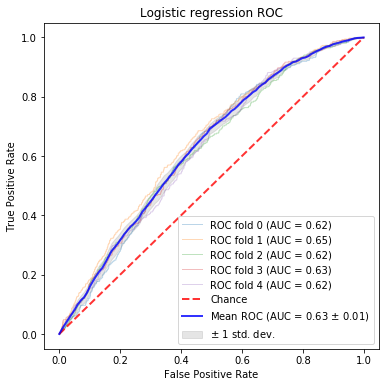

In [10]:
logreg=LogisticRegression(class_weight='balanced', random_state=rs, solver='lbfgs', max_iter=1000)

cv_mean_roc(X, Y, logreg, 'Logistic regression', n_splits=5)